# Ciencia de datos
## Práctica 11. Clasificación de datos con sklearn
###  Alberto Benavides

Para esta práctica se parte de los datos cuyas características fueron seleccionadas por el algoritmo del umbral de varianza, a saber

In [91]:
import pandas as pd

x = pd.read_csv("/mnt/c/Users/bena8/Documents/FIME/Tesis/Resultados/xVT.csv")
x.sample(3)

,ac1,ac2,ac3,ac4,ac48
15,0.895262,0.842421,0.792705,0.707147,0.466082
32,0.903920,0.826842,0.732156,0.614444,-0.008971
10,-0.081445,0.057375,-0.049496,0.012841,-0.031916


In [92]:
y = pd.read_csv("/mnt/c/Users/bena8/Documents/FIME/Tesis/Resultados/y.csv")
y.sample(3)

,cie
10,a34
38,z21
6,a17.0


Asimismo, se cargan las CIEs correspondientes a cada registro

In [94]:
y = pd.read_csv("/mnt/c/Users/bena8/Documents/FIME/Tesis/Resultados/y.csv")
y.sample(3)

,cie
26,g00-g03
2,a01.0
8,a27


Las características seleccionadas corresponden a las autocorrelaciones con retrasos de 1, 2, 3, 4 y 48 semanas. Es importante primero normalizar las características que serán la entrada de los algoritmos de agrupamiento

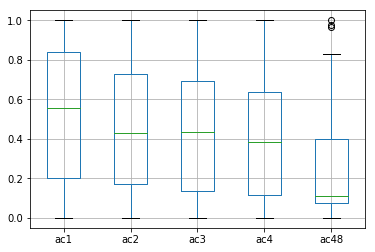

In [95]:
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit(x).transform(x)

import matplotlib.pyplot as plt

# https://stackoverflow.com/a/20763459
X = pd.DataFrame(data=X)
# https://stackoverflow.com/a/11346337
X.columns = x.columns
X.boxplot()

De las CIEs, nos interesan las CIEs generales, o sea la primera letra de cada CIE

In [96]:
cieG = y.cie.str[0]

y.cie.str[0].unique()

array(['a', 'b', 'g', 'i', 'j', 'p', 't', 'u', 'w', 'x', 'z'],
      dtype=object)

Con base en esto, se utilizan dos algoritmos para realizar el agrupamiento. Priero $k$-medias, por ser el algoritmo más utilizado. Con este algoritmo es necesario especificar el número de agrupamientos. Para ello, se utilizará el método del codo

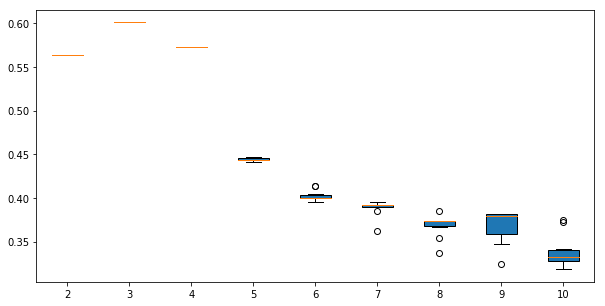

Clusters elegidos: 3



In [121]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

clusters = range(2, len(cieG.unique()) + 1)
l = len(clusters) - 1
results_test = np.zeros(shape=(0, l))
for j in range(10):
    kmeans = [KMeans(n_clusters=i) for i in clusters]
    y_pred_test = [kmeans[i].fit(X).predict(X) for i in range(len(kmeans))]
    score = [silhouette_score(X, y_pred_test[i]) for i in range(len(kmeans) - 1)]
    results_test = np.vstack((results_test, score))
    
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.boxplot(results_test, patch_artist=True)
ax.set_xticklabels(clusters) # https://matplotlib.org/gallery/statistics/boxplot_demo.html
plt.show()

from kneed import KneeLocator 
kneedle = KneeLocator(
            range(2, len(cieG.unique())), # Entre los clusters definidos
            np.mean(results_test, axis=0), 
            curve='convex', direction='increasing')
# Se actualiza el número de clusters
n_clusters = kneedle.knee
print("Clusters elegidos: {}\n". format(n_clusters))

Con este conocimiento, se puede ejecutar $k$-medias con $k = 6$ para este conjunto de datos y obtener los grupos

In [130]:
y_pred = KMeans(n_clusters=3).fit(X).predict(X)
y_pred

array([0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 2, 0, 2, 1, 2, 0, 1, 2, 2, 1], dtype=int32)

Estos valores se pueden mostrar en una gráfica

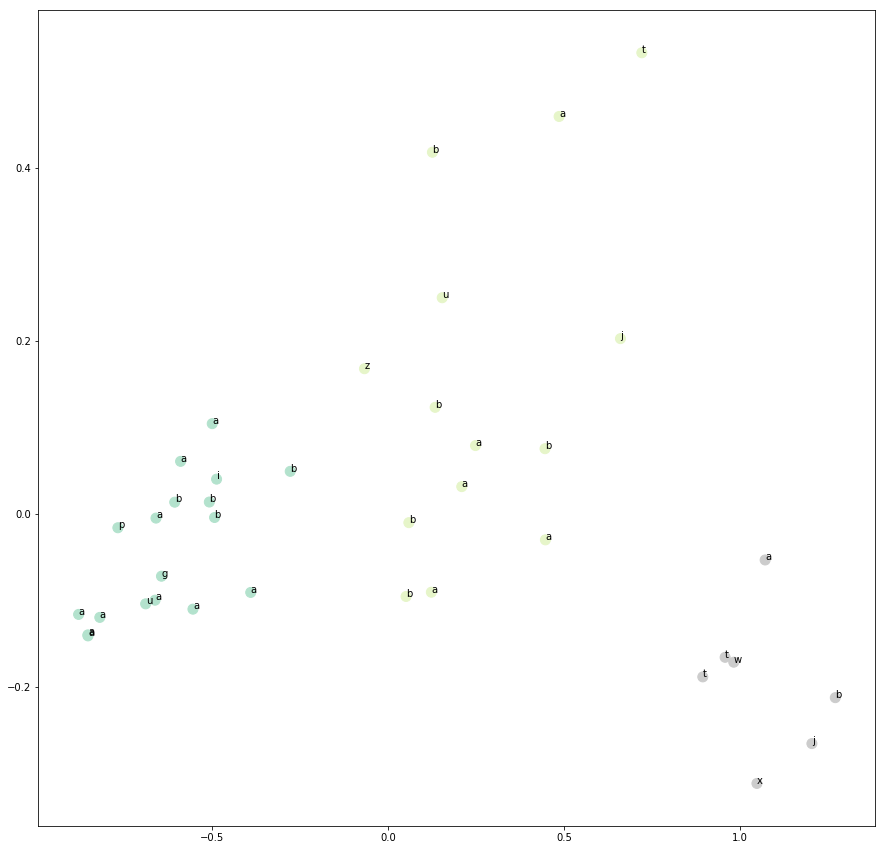

In [131]:
from sklearn.decomposition import PCA
from matplotlib import cm as cm

cmap = cm.get_cmap('Pastel2', 30)

pca = PCA(n_components = 2).fit_transform(X)
pca = pd.DataFrame(data=pca)

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(pca[0], pca[1], c=y_pred, s = 100, cmap = cmap)
for i, txt in enumerate(y.cie.str[0]):
    ax.annotate(txt, (pca[0][i], pca[1][i]))

plt.show()

Mas se nota que el agrupamiento es más al azar que nada. Así que se probará con otro método que quizás sea más adecuado para estas series de tiempo, que es el agrupamiento de Affinity propagation

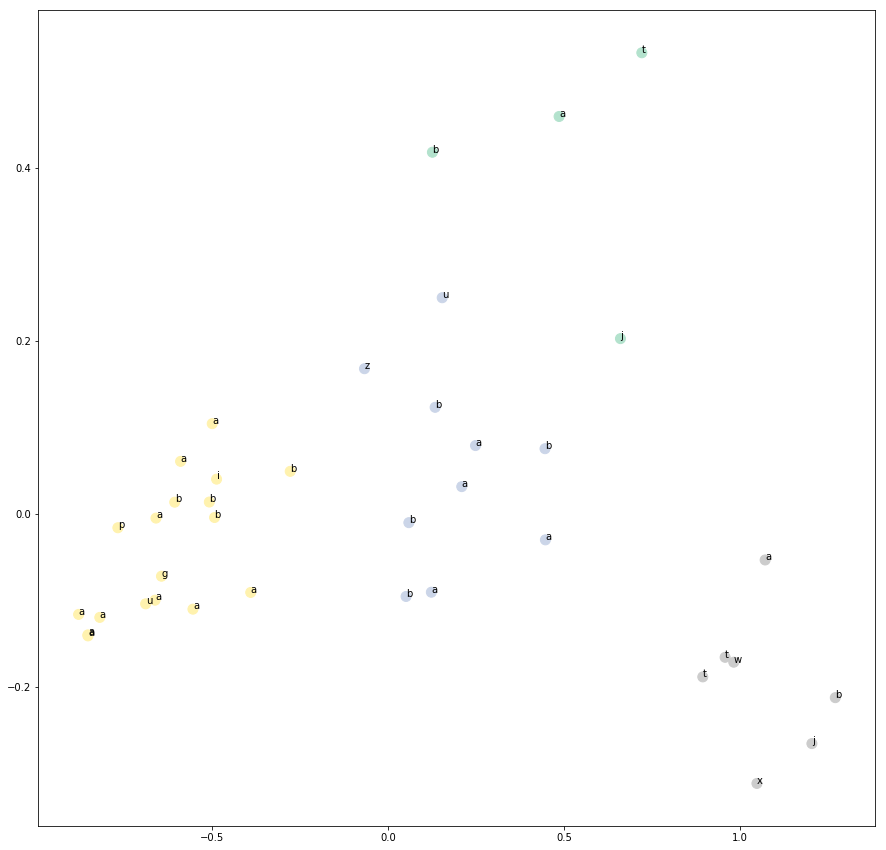

0.5593729217401119


In [132]:
from sklearn.cluster import AffinityPropagation


y_pred_ap = AffinityPropagation().fit(X).predict(X)

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(pca[0], pca[1], c=y_pred_ap, s = 100, cmap= cmap)
for i, txt in enumerate(y.cie.str[0]):
    ax.annotate(txt, (pca[0][i], pca[1][i]))

plt.show()

print(silhouette_score(X, y_pred_ap, metric='euclidean'))

Aquí aparecen menos dispersas, pero bien podría ser debido a que hay más grupos que se forman, aún así no mejora la medida del error. Pese a todo esto, es posible mostrar las características de estos agrupamientos por separado para compararlas

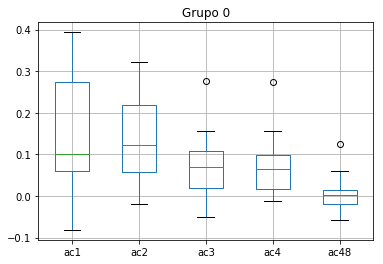

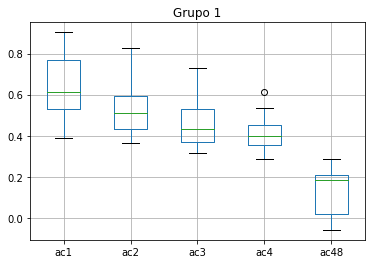

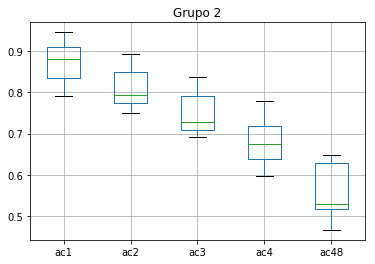

<Figure size 432x288 with 0 Axes>

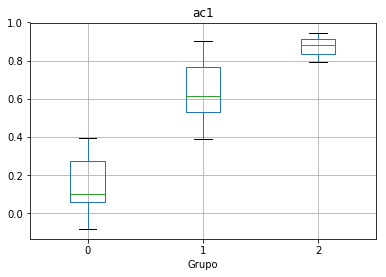

<Figure size 432x288 with 0 Axes>

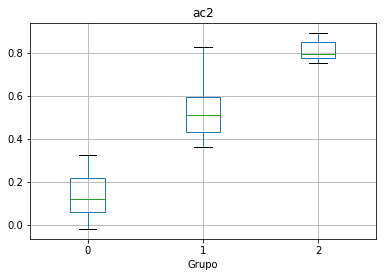

<Figure size 432x288 with 0 Axes>

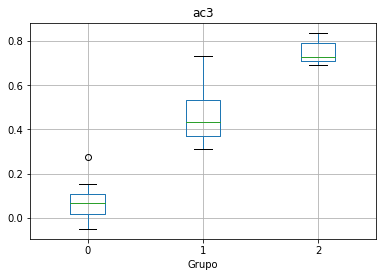

<Figure size 432x288 with 0 Axes>

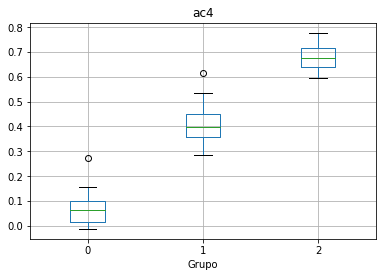

<Figure size 432x288 with 0 Axes>

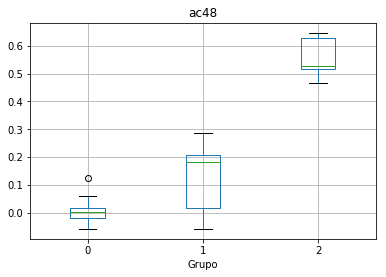

In [180]:
t = pd.DataFrame(data=y_pred)

all = x.join(t)
all = all.rename(columns = {0:'y'})

for n, g in all.groupby('y'):
    plt.figure()
    g.iloc[:, :-1].boxplot()
    plt.title("Grupo " + str(n))
    plt.show()

for n in all.iloc[:, :-1]:
    plt.figure()
    all.boxplot(column=[n], by='y')
    plt.suptitle('')
    plt.title(n)
    plt.xlabel('Grupo')
    plt.show()

Esto muestra que las diferencias entre grupos se deben, principalmente, a que los grupos 0 y 1 tienen autocorrelaciones con retraso de 1, 2, 3 y 4 semansa distintas y que no se sobrelapan. Entre los grupos 1 y 2 hay un poco de sobrelapamiento en las autocorrelaciones mencionadas, pero se distinguen por la autocorrelación de 48 semanas. 

Con esta información se puede concluir que los grupos generados no tienen relación con la CIE propuesta por la OMS, sin embargo es posible extraer información de interés respecto a las autocorrelaciones de estas series de tiempo.